# **Name Entity Recognition Model (Using Bidirectional LSTM)**
### ***{ Dataset : Kaggle "Annotated Corpus for Named Entity Recognition" }***

The Named Entity Recognition models try to correctly classify text to a set of predefined classes. Classes like people (PER), organizations (ORG) or places (LOC) are used.

In Named Entity Recognition, We need to extract an important information from unstructured data like text.

for eg. we were provided with an unstructured data which contains COVID-19 patients and the name of medical organization, paitent belongs to, location and date.   

The NER task is to correctly identify and classify text into a set of predefined classes. Classes like people (PER), organizations (ORG) or places (LOC) are used.

I used Google Colab for this project ....

In [61]:
from google.colab import files
uploaded = files.upload()

Saving NER_dataset.csv to NER_dataset.csv


In [63]:
import pandas as pd
data = pd.read_csv('NER_dataset.csv')
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


# Data Preprocessing

Modification done to fit data easily into the neural nettwork.

1. Tokenization
2. Grouped by
3. Padding
4. Categorize the target variable
5. Data Partition ( Raw Data = (Training(90%)+ Testing(10%)) ), (Training = (Train (75%) + Validation (25%))

In [66]:
def get_dict_map(data, word_or_tag):
    tok2idx = {}
    idx2tok = {}
    
    if word_or_tag == 'word':
        unique_list = list(set(data['Word'].to_list()))
    else:
        unique_list = list(set(data['Tag'].to_list()))
    
    idx2tok = {id:value for  id, value in enumerate(unique_list)}
    tok2idx = {value:id for  id, value in enumerate(unique_list)}
    return tok2idx, idx2tok


token2idx, idx2token = get_dict_map(data, 'word')
tag2idx, idx2tag = get_dict_map(data, 'tag')
data['Word_idx'] = data['Word'].map(token2idx)
data['Tag_idx'] = data['Tag'].map(tag2idx)

In [67]:
data.head(10)

,Sentence #,Word,POS,Tag,Word_idx,Tag_idx
0,Sentence: 1,Thousands,NNS,O,7121,9
1,NaN,of,IN,O,31348,9
2,NaN,demonstrators,NNS,O,13397,9
3,NaN,have,VBP,O,558,9
4,NaN,marched,VBN,O,24765,9
5,NaN,through,IN,O,15102,9
6,NaN,London,NNP,B-geo,1952,3
7,NaN,to,TO,O,34615,9
8,NaN,protest,VB,O,26533,9
9,NaN,the,DT,O,11240,9


In [72]:
data_fillna = data.fillna(method='ffill')
# Groupby and collect columns
data_group = data_fillna.groupby(
['Sentence #'],as_index=False
)['Word', 'POS', 'Tag', 'Word_idx', 'Tag_idx'].agg(lambda x: list(x))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """


In [73]:
data_group

,Sentence #,Word,POS,Tag,Word_idx,Tag_idx
0,Sentence: 1,"[Thousands, of, demonstrators, have, marched, ...","[NNS, IN, NNS, VBP, VBN, IN, NNP, TO, VB, DT, ...","[O, O, O, O, O, O, B-geo, O, O, O, O, O, B-geo...","[7121, 31348, 13397, 558, 24765, 15102, 1952, ...","[9, 9, 9, 9, 9, 9, 3, 9, 9, 9, 9, 9, 3, 9, 9, ..."
1,Sentence: 10,"[Iranian, officials, say, they, expect, to, ge...","[JJ, NNS, VBP, PRP, VBP, TO, VB, NN, TO, JJ, J...","[B-gpe, O, O, O, O, O, O, O, O, O, O, O, O, O,...","[7946, 32259, 32454, 27188, 22574, 34615, 1347...","[0, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, ..."
2,Sentence: 100,"[Helicopter, gunships, Saturday, pounded, mili...","[NN, NNS, NNP, VBD, JJ, NNS, IN, DT, NNP, JJ, ...","[O, O, B-tim, O, O, O, O, O, B-geo, O, O, O, O...","[2468, 12467, 17570, 10094, 8559, 31270, 5437,...","[9, 9, 11, 9, 9, 9, 9, 9, 3, 9, 9, 9, 9, 9, 13..."
3,Sentence: 1000,"[They, left, after, a, tense, hour-long, stand...","[PRP, VBD, IN, DT, NN, JJ, NN, IN, NN, NNS, .]","[O, O, O, O, O, O, O, O, O, O, O]","[12744, 29829, 3875, 21744, 33323, 3196, 19985...","[9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]"
4,Sentence: 10000,"[U.N., relief, coordinator, Jan, Egeland, said...","[NNP, NN, NN, NNP, NNP, VBD, NNP, ,, NNP, ,, J...","[B-geo, O, O, B-per, I-per, O, B-tim, O, B-geo...","[3705, 29736, 13514, 5399, 7485, 30093, 2097, ...","[3, 9, 9, 5, 6, 9, 11, 9, 3, 9, 0, 9, 0, 9, 9,..."
...,...,...,...,...,...,...
47954,Sentence: 9995,"[Opposition, leader, Mir, Hossein, Mousavi, ha...","[NNP, NN, NNP, NNP, NNP, VBZ, VBN, PRP, VBZ, T...","[O, O, O, B-per, I-per, O, O, O, O, O, O, O, O...","[33174, 22118, 15458, 19585, 33086, 1391, 3009...","[9, 9, 9, 5, 6, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, ..."
47955,Sentence: 9996,"[On, Thursday, ,, Iranian, state, media, publi...","[IN, NNP, ,, JJ, NN, NNS, VBN, DT, NN, IN, DT,...","[O, B-tim, O, B-gpe, O, O, O, O, O, O, O, O, B...","[28450, 1195, 27557, 7946, 5547, 4384, 20581, ...","[9, 11, 9, 0, 9, 9, 9, 9, 9, 9, 9, 9, 13, 14, ..."
47956,Sentence: 9997,"[Following, Iran, 's, disputed, June, 12, elec...","[VBG, NNP, POS, JJ, NNP, CD, NNS, ,, NNS, NNS,...","[O, B-geo, O, O, B-tim, I-tim, O, O, O, O, O, ...","[8916, 30742, 27006, 29384, 20045, 17641, 7925...","[9, 3, 9, 9, 11, 12, 9, 9, 9, 9, 9, 9, 9, 9, 9..."
47957,Sentence: 9998,"[Since, then, ,, authorities, have, held, publ...","[IN, RB, ,, NNS, VBP, VBN, JJ, NNS, IN, DT, VB...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[4677, 11480, 27557, 29943, 558, 23426, 3202, ...","[9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, ..."


In [75]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
def get_pad_train_test_val(data_group, data):

    #get max token and tag length
    n_token = len(list(set(data['Word'].to_list())))
    n_tag = len(list(set(data['Tag'].to_list())))

    #Pad tokens (X var)    
    tokens = data_group['Word_idx'].tolist()
    maxlen = max([len(s) for s in tokens])
    pad_tokens = pad_sequences(tokens, maxlen=maxlen, dtype='int32', padding='post', value= n_token - 1)

    #Pad Tags (y var) and convert it into one hot encoding
    tags = data_group['Tag_idx'].tolist()
    pad_tags = pad_sequences(tags, maxlen=maxlen, dtype='int32', padding='post', value= tag2idx["O"])
    n_tags = len(tag2idx)
    pad_tags = [to_categorical(i, num_classes=n_tags) for i in pad_tags]

    #Split train, test and validation set
    tokens_, test_tokens, tags_, test_tags = train_test_split(pad_tokens, pad_tags, test_size=0.1, train_size=0.9, random_state=2020)
    train_tokens, val_tokens, train_tags, val_tags = train_test_split(tokens_,tags_,test_size = 0.25,train_size =0.75, random_state=2020)

    print(
        'train_tokens length:', len(train_tokens),
        '\ntrain_tokens length:', len(train_tokens),
        '\ntest_tokens length:', len(test_tokens),
        '\ntest_tags:', len(test_tags),
        '\nval_tokens:', len(val_tokens),
        '\nval_tags:', len(val_tags),
    )
    
    return train_tokens, val_tokens, test_tokens, train_tags, val_tags, test_tags

train_tokens, val_tokens, test_tokens, train_tags, val_tags, test_tags = get_pad_train_test_val(data_group, data)

train_tokens length: 32372 
train_tokens length: 32372 
test_tokens length: 4796 
test_tags: 4796 
val_tokens: 10791 
val_tags: 10791


In [80]:
test_tags[0].shape

(104, 17)

## Model training

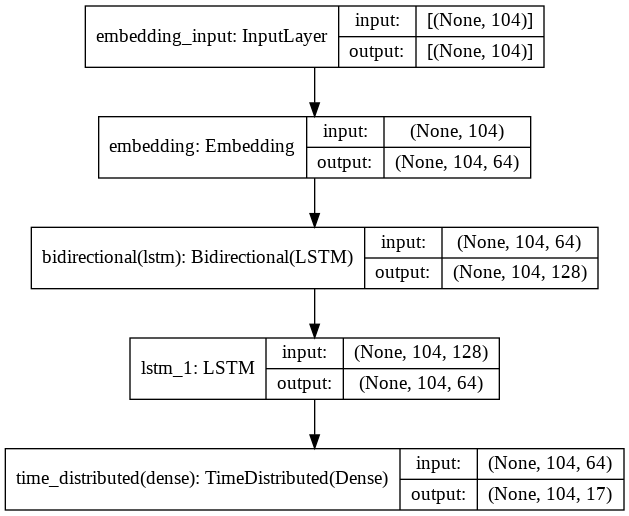

**1. Embedding Layer :** 
    One can imagine the Embedding layer as a simple matrix multiplication that transforms words into their corresponding word embeddings OR turns positive integers (indexes) into dense vectors of fixed size.

**2. Bidirectional LSTM :**
    A Bidirectional LSTM, or biLSTM, is a sequence processing model that consists of two LSTMs: one taking the input in a forward direction, and the other in a backwards direction.

**3. LSTM:**
    LSTM networks are well-suited to classifying, processing and making predictions based on time series data.

**4. Time Distributed Dense Layer:**
    It allows to use a layer for each input. That means that instead of having several input “models”, we can use “one model” applied to each input.

In [22]:
import numpy as np
import tensorflow
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from tensorflow.keras.utils import plot_model

from numpy.random import seed
seed(1)
tensorflow.random.set_seed(2)

input_dim = len(list(set(data['Word'].to_list())))+1
output_dim = 64
input_length = max([len(s) for s in data_group['Word_idx'].tolist()])
n_tags = len(tag2idx)

In [23]:
def get_bilstm_lstm_model():
    model = Sequential()

    # Add Embedding layer
    model.add(Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length))

    # Add bidirectional LSTM
    model.add(Bidirectional(LSTM(units=output_dim, return_sequences=True, dropout=0.2, recurrent_dropout=0.2), merge_mode = 'concat'))

    # Add LSTM
    model.add(LSTM(units=output_dim, return_sequences=True, dropout=0.5, recurrent_dropout=0.5))

    # Add timeDistributed Layer
    model.add(TimeDistributed(Dense(n_tags, activation="relu")))

    #Optimiser 
    # adam = k.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999)

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    
    return model

In [24]:
def train_model(X, y, model):
    loss = list()
    for i in range(25):
        # fit model for one epoch on this sequence
        hist = model.fit(X, y, batch_size=1000, verbose=1, epochs=1, validation_split=0.2)
        loss.append(hist.history['loss'][0])
    return loss
    
results = pd.DataFrame()
model_bilstm_lstm = get_bilstm_lstm_model()
plot_model(model_bilstm_lstm)
results['with_add_lstm'] = train_model(train_tokens, np.array(train_tags), model_bilstm_lstm)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 104, 64)           2251072   
_________________________________________________________________
bidirectional (Bidirectional (None, 104, 128)          66048     
_________________________________________________________________
lstm_1 (LSTM)                (None, 104, 64)           49408     
_________________________________________________________________
time_distributed (TimeDistri (None, 104, 17)           1105      
Total params: 2,367,633
Trainable params: 2,367,633
Non-trainable params: 0
_________________________________________________________________
26/26 [==============================] - 134s 5s/step - loss: 0.0933 - accuracy: 0.9690 - val_loss: 0.1054 - val_accuracy: 0.9694
